# RandomForests for RNASeq expression classification

# 1. Introduction 
### Machine learning
There are three main categories of machine learning. Unsupervised, supervised, and reinforcement learning. Random forest classification is a typical supervised learning method. Supervised learning is a task of learning a function that maps output to corresponding input based on example input-output pairs.[1] There's always labeled training data, from which algorithms and rules can be drawn to predict class labels of unseen samples. 


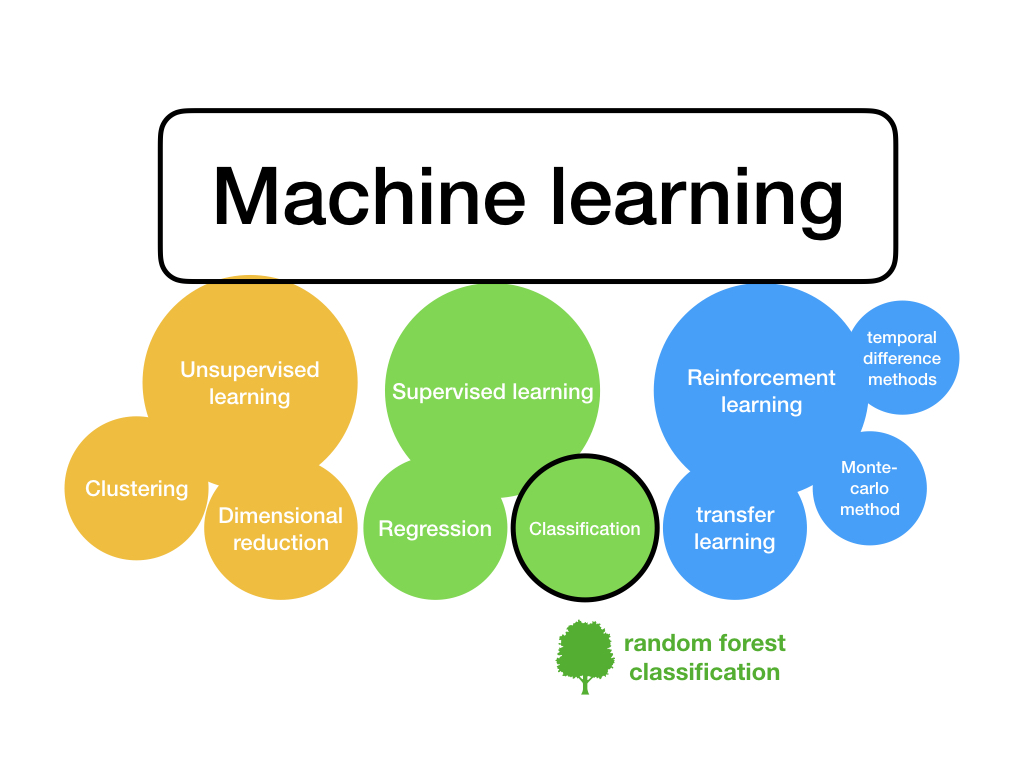

##### Quick terminology of machine learning: features, labels, missing data


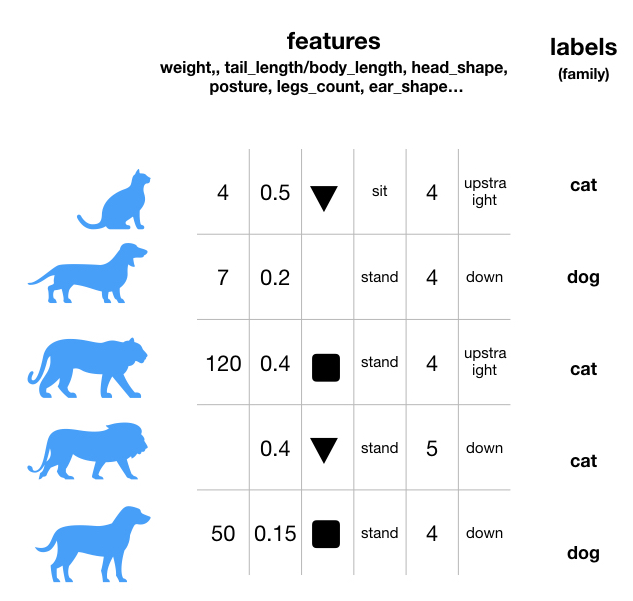

### Random Forest
The random forest is a supervised learning algorithm that randomly creates and merges multiple decision trees into one “forest.” The goal is not to rely on a single learning model, but rather a collection of decision models to improve accuracy. The primary difference between these decision models and the standard decision tree algorithms is that the root nodes feature splitting nodes are generated randomly.[2]

Random forest classifiers can serve both classification and regressional purposes. It can deal with a wide range of data types, both categorical and numerical data types, and missing values are allowed in a random forest classifier. 

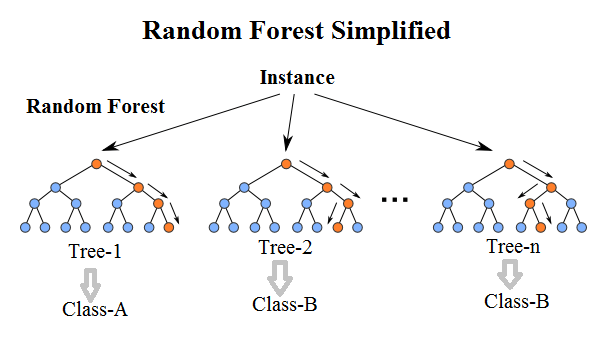

Reference:
1. Supervised learning, Wikipedia, retrieved on 2020/03/09, link:https://en.wikipedia.org/wiki/Supervised_learning
2. Random forest, DeepAI, retrieved on 2020/03/09, link: https://deepai.org/machine-learning-glossary-and-terms/random-forest
3. Random Forest Simple Explanation
, Wil Koehrsen, retrieved on 2020/03/09 from https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

# 2.1 Getting started

Here, we import python packages for data frame management, number/ array management, machine learning, and plotting. You could find the packages and their descriptions on the PyPI "project links - homepage", for example pandas:
- https://pypi.org/project/pandas/
- https://pandas.pydata.org/

## New to binder/ jupyter notebook?
- shift+enter to run a cell!
- dd to delete a cell
- alt+enter to run a cell plus insert a cell below

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


In [ ]:
import pandas as pd # dataframe manipulation
import numpy as np # arrays, matrices, numbers 
from sklearn.model_selection import train_test_split # sklearn: a machine learning package
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt # for plotting the results
import seaborn as sns # for plotting the results
import collections # for specific datatypes (default dictionary)
import time

# 2.2 The dataset

In this session we will use an miRNA expression dataset that contains 714 expression signatures across 29 tumor/normal pairs measured in human cervical tissue. 

We will use this dataset to perform several pre-processing steps, feature scaling/normalization and to train a RandomForest classifier with Python.

First, let's import our dataset and have a look at the data.

In [ ]:
try:
    exprm = pd.read_csv("./datasets/exprm.txt", sep="\t")
except Exception:
    print("An error occured while reading the data")

Print the first 5 rows.

In [ ]:
exprm.head(n=5)

### Question
- What is the dimension of the dataset above/ what type of numerical data does it contain?
- Which dimenson contains the features, which one the instances? 

#### TIp 
You can access a dataframe's dimension with the `dim()` function or `exprm.shape`

# 2.3 Pre-proccesing -  Normalization

A common normalization technique in RNASEq is the Median of Ratios method, which is used by [DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8), one of the  major statistical tools for differential expression analysis. Briefly, this method corrects for differences in sequencing library size (number of reads), composition of the library (tissue specific expression) to make samples comparable. Without accounting for these confounding factors, a classifier might discriminate between samples based on technical variation which mask the true biological signal. 

Here we implement our own version of the **Median of Ratios** method. However, several more RNA sepecific normalization methods exist, such as Trimmed Mean (TMM) for example.


First, we perform a log transformation on the raw read counts to reduce the skewness of the dataset

In [6]:
exprm_log2 = exprm.apply(np.log2) # Perform a log transformation of our dataset.
exprm_log2

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
let-7a,9.756556,9.661778,12.426527,12.708222,10.507795,9.199672,3.169925,12.139871,10.938109,13.311606,...,5.209453,11.632086,6.857981,10.749869,6.087463,13.565221,13.813581,15.258419,7.629357,10.473706
let-7a*,1.584963,3.584963,4.906891,6.189825,2.584963,1.000000,-inf,7.636625,3.321928,7.434628,...,-inf,9.339850,2.000000,7.727920,2.584963,1.000000,6.321928,7.357552,4.169925,0.000000
let-7b,9.929258,11.446049,12.262095,14.567837,10.780540,8.988685,5.044394,12.589183,10.506803,14.144499,...,6.629357,16.643264,7.523562,14.787188,8.647458,13.820877,14.556566,16.158353,9.385862,11.283088
let-7b*,3.906891,4.169925,4.754888,6.894818,3.459432,1.584963,-inf,6.857981,4.087463,7.864186,...,-inf,8.383704,0.000000,7.562242,2.321928,5.087463,6.845490,7.845490,2.000000,3.906891
let-7c,9.693487,10.288866,11.537704,12.646784,9.477758,8.405141,4.523562,10.967226,8.894818,11.685625,...,5.087463,10.740624,4.459432,11.610564,7.636625,11.637531,10.505812,12.522336,7.383704,8.326429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Candidate-60,-inf,-inf,-inf,-inf,2.321928,-inf,-inf,-inf,-inf,-inf,...,-inf,1.000000,-inf,-inf,1.584963,-inf,-inf,1.000000,-inf,-inf
Candidate-61,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,1.000000,-inf,-inf,-inf
Candidate-62,-inf,0.000000,-inf,-inf,-inf,-inf,-inf,-inf,0.000000,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,1.584963,2.000000,-inf,-inf
Candidate-63,-inf,1.000000,-inf,-inf,-inf,-inf,-inf,1.000000,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,2.807355,-inf,-inf


In the following step, we calculate the mean for each miRNA expression across all samples

In [7]:
expr_means =  exprm_log2.apply(np.mean,1) # Calculate the geometric mean for each gene
expr_means

let-7a          10.756907
let-7a*              -inf
let-7b          12.279387
let-7b*              -inf
let-7c          10.018540
                  ...    
Candidate-60         -inf
Candidate-61         -inf
Candidate-62         -inf
Candidate-63         -inf
Candidate-64         -inf
Length: 714, dtype: float64

Some samples might contains 0 (-inf) counts which we need to filter first before proceeding.

In [8]:
idxs = expr_means > 0 # Filter 0 Counts values
expr_means = expr_means[idxs] # Select geometric means with > 0 expression.

Next, we caclulate the row-wise mean to expression ratio for each sample across all miRNA.

In [9]:
mean_ratio = exprm_log2[idxs].sub(expr_means,"index") # Calculate mean expr. ratios for each gene's expression per sample.
mean_ratio

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
let-7a,-1.000351,-1.095129,1.669620,1.951315,-0.249112,-1.557235,-7.586982,1.382964,0.181202,2.554699,...,-5.547454,0.875179,-3.898926,-0.007038,-4.669444,2.808314,3.056674,4.501512,-3.127550,-0.283201
let-7b,-2.350128,-0.833337,-0.017292,2.288451,-1.498847,-3.290702,-7.234992,0.309796,-1.772583,1.865112,...,-5.650030,4.363878,-4.755825,2.507802,-3.631928,1.541490,2.277179,3.878967,-2.893524,-0.996298
let-7c,-0.325053,0.270326,1.519164,2.628244,-0.540781,-1.613398,-5.494978,0.948687,-1.123722,1.667085,...,-4.931077,0.722084,-5.559108,1.592024,-2.381915,1.618991,0.487272,2.503797,-2.634835,-1.692110
let-7d,-2.110387,-1.645424,0.247660,2.624036,-0.705545,-2.705545,-8.260134,1.229714,-0.587709,2.216612,...,-8.260134,3.246173,-5.675172,2.944437,-6.675172,0.786990,3.216106,4.009285,-3.867817,-0.993348
let-7e,-1.957762,-2.120236,0.263411,3.143445,-1.091854,-2.439778,-6.188716,1.542226,-1.686216,2.164431,...,-1.932376,3.975353,-1.073239,0.306695,-4.110713,2.694606,0.520942,1.862946,-3.250117,-4.714785
let-7f,-1.431948,-2.999270,1.187669,3.238139,-0.437028,-2.100417,-10.584233,1.469693,-0.419326,2.384074,...,-8.262304,4.114960,-4.726252,0.311343,-5.454950,2.223927,2.000495,2.757981,-4.883793,-2.308108
let-7g,-0.388793,-1.758296,1.715468,2.795050,-0.247481,-2.238728,-6.192924,0.836363,-0.475248,1.833599,...,-6.022999,3.872323,-6.192924,0.326712,-6.870996,1.265482,1.321790,2.556945,-5.492485,1.830137
let-7i,-1.841367,-1.506329,0.078633,2.162742,-0.950126,-3.278523,-6.946902,-0.434585,-1.161800,0.934868,...,-6.053817,5.284448,-5.847366,1.595025,-2.709863,3.452147,2.777125,2.715894,-4.026336,-2.515852
miR-100,0.917053,0.453747,2.474932,1.508195,-1.192245,-3.362170,-1.589581,1.784186,-2.859670,1.797701,...,-6.947133,3.475983,-5.362170,2.855384,-4.139778,-2.487701,3.690398,2.050047,-4.625205,-0.924765
miR-101,-0.153185,0.610748,2.193928,2.190357,-0.126218,-1.218141,-3.765628,1.009665,-0.266396,1.115132,...,-4.006636,3.593276,-4.658713,1.830848,-3.378605,0.976875,0.762751,0.757934,-4.881106,-3.881106


We select the median ratio per miRNA which becomes our size factor. These size factors serve as a "pseudo" references to normalize our raw read_counts.

In [10]:
size_factors = mean_ratio.apply(lambda counts: np.median(counts),1) # Select median ratio for normalization

Finally, we divide each miRNA expression (per sample) by its corresponding size factor.

In [11]:
exprm_normalized = exprm[idxs].divide(np.exp(size_factors),'index')

### Question
- Why did we perform a log transformation ?
- What is the rationale behind size-factors ?



# 2.4 Pre-processing - Transformation

As a convention, most machine learning toolkits, such as Scikit-learn, expect the features of a dataset to be arranged in rows and attributes in columns.

This can be easily accomplished by Pandas's `transpose()` or `.T` command.


In [12]:
exprm_normalized_t = exprm_normalized.transpose()

The expression dataset is currently missing a definition of which sample belongs to the tumor or normal class. 

For your convenience, we prepared a metadata file that contains the mampping between samples and biological condition.

In [13]:
try:
    exprm_meta = pd.read_csv("./datasets/exprm_meta.txt", sep="\t")
    exprm_meta = exprm_meta.set_index("sample")
except Exception:
    print("An error occured while reading the data")

To ensure that the relationship between labels (N,T) and expression measurements, we merge the metadata `exprm_meta` with the expression measurements `exprm_normalized_t` by the shared index name.

In [14]:
exprm_all = pd.merge(exprm_normalized_t, exprm_meta, left_index=True, right_index=True)
exprm_all.head(n=5)

,let-7a,let-7b,let-7c,let-7d,let-7e,let-7f,let-7g,let-7i,miR-100,miR-101,...,miR-30d,miR-320a,miR-335,miR-423-5p,miR-424,miR-451,miR-484,miR-99a,miR-99b,condition
N1,461.133238,824.339370,519.774909,53.624715,113.030646,272.521920,228.290651,192.462612,93.418331,74.333529,...,102.579715,217.478852,76.826994,21.811653,7.749540,73.866171,14.870288,236.846561,17.781587,N
N2,431.812627,2358.878812,785.312090,74.017212,100.991879,91.958188,88.354100,242.774416,67.758360,126.226747,...,168.035343,950.165907,48.460104,62.918230,550.217320,100.598690,26.766519,250.616710,68.162751,N
N3,2934.726560,4152.979471,1866.293240,274.921074,527.030466,1674.884280,981.598729,728.323247,275.042812,378.212734,...,213.951977,853.865308,128.241982,68.790599,27.898343,1022.870601,56.507096,642.377445,71.867248,N
N4,3567.518645,20533.236858,4025.744551,1427.474808,3879.827071,6938.053670,2074.533838,3088.186400,140.728903,377.277721,...,503.129078,1393.148661,1154.768814,114.091724,533.684969,375.662243,44.610865,887.486095,114.098518,N
N5,776.196525,1487.192771,447.583949,141.992203,205.996680,543.128045,251.783649,356.974223,21.650600,75.736048,...,56.663081,678.919221,20.684191,99.830259,63.546226,73.162684,35.688692,114.292236,65.199153,N


### Question 
- What is the advantage of merging the two files by a common column? Couldn't we just simply 'copy & paste' the class labels? 
- What happend to the rows/columns of our dataframe after transposition? 

# 3. 1 Train and Test sets
For any supervised machine learning algorithm, we need to split our dataset into a training and a testing (validating) set. The testing set remains untouched until the algorithm is derived from the training set. The algorithm is then tested on the test-set to see how well it can predict new samples.

In a situation where no dedicated train/test sets are available, we usually reserve 2/3 of the initial dataset for training and 1/3 for testing. We need to define the size of our test set to split the dataset accordingly. 

In [15]:
test_size = 0.33
random_state = 123 # Desinating a random state ensures results are reproducible between us.

The purpose is to see how well miRNA expression levels can predict the conditions (N, T). Therefore, features are the expression levels and classes are the conditions in this case. We separate these two dataframe with same column names before train, test split.

In [16]:
classes = exprm_all['condition']
features = exprm_all.drop(columns = 'condition')

Split the dataset into train and test-set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=test_size, random_state=random_state)

# 3.1 Random Forest  - Training (Tilman)

Create a new RandomForest instance with n trees.

In [18]:
max_depth=2
random_state=123
n_trees=5000
rf = RandomForestClassifier(max_depth=2, 
                            random_state=random_state,
                            bootstrap=True,
                            max_features = 'sqrt',
                            n_estimators=n_trees)

# Criterion splitting/scoring
# Print one tree and explain decision path
# Plot one tree

We train our classifier on the testset that we previously created. In this steps, the actual "learning" takes place.

In [22]:
# training =fitting (take approx 12 secs)
rf.fit(X_train, y_train) #We should use OOB score here and plot it shomewhere.

12.644626140594482 s


# 3.2 Random Forest - Prediciting

Let's predict the classes of our test-set.

In [23]:
predicts = rf.predict(X_test) #classes predictions for the test-set
probs = rf.predict_proba(X_test)[:, 1] #Probability of being a T condition

In [24]:
print("predicts\n",predicts)
print("truth\n", y_test.values)

predicts
 ['T' 'T' 'T' 'T' 'T' 'N' 'T' 'T' 'N' 'N' 'T' 'T' 'N' 'T' 'T' 'N' 'T' 'T'
 'N' 'N']
truth
 ['T' 'T' 'N' 'T' 'N' 'N' 'T' 'T' 'N' 'N' 'T' 'T' 'N' 'N' 'N' 'N' 'T' 'N'
 'N' 'T']


# 3.3 - Measuring performance - Confusion matrix
To see how well the model performs on test set, printing out the results is not feasible when we are working with large dataset. Scikit-learn has built in function `confusion_matrix` to do this task. We could then visualize the confusion matrix to analyse the True Positives, False Positives, False negatives, and true negatives. 

In [27]:
# plot the confusion matrix with labels
def plot_cm(cm, labels = ["T","N"]):
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    sns.heatmap(df_cm, annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['T', 'N'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[[8 1]
 [5 6]]


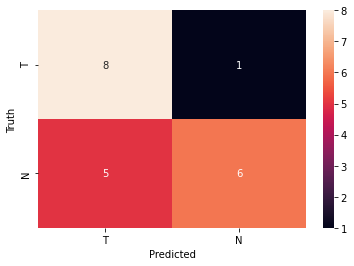

In [28]:
labels = ["T","N"]
cm = confusion_matrix(y_test, predicts, labels)
print(cm)
plot_cm(cm, labels = labels )

# 3.4 Feature importances 

In [29]:
importance = rf.feature_importances_

In [30]:
# sort the features by importance
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns),reverse=True))

[(0.0829, 'miR-143'), (0.0801, 'miR-99b'), (0.0664, 'miR-125b'), (0.0659, 'miR-199a-5p'), (0.0648, 'miR-125a-5p'), (0.0535, 'miR-23b'), (0.0509, 'miR-424'), (0.0437, 'miR-100'), (0.0338, 'miR-142-5p'), (0.0308, 'miR-126'), (0.0307, 'miR-199b-3p'), (0.0287, 'miR-99a'), (0.0251, 'miR-151-5p'), (0.0234, 'miR-10b'), (0.0198, 'miR-21'), (0.0177, 'miR-27b'), (0.0176, 'let-7e'), (0.0169, 'miR-186'), (0.0152, 'miR-484'), (0.0143, 'miR-181a'), (0.0139, 'miR-335'), (0.0137, 'miR-27a'), (0.0123, 'miR-26a'), (0.0117, 'miR-185'), (0.0113, 'let-7a'), (0.0112, 'miR-15b'), (0.0112, 'let-7i'), (0.0106, 'miR-451'), (0.0104, 'miR-145'), (0.0103, 'miR-320a'), (0.0099, 'let-7c'), (0.0098, 'miR-423-5p'), (0.0095, 'let-7f'), (0.009, 'miR-30d'), (0.0079, 'let-7b'), (0.0074, 'miR-23a'), (0.0074, 'miR-19b'), (0.0066, 'miR-101'), (0.0065, 'miR-191'), (0.0065, 'let-7g'), (0.0048, 'miR-29b'), (0.0043, 'miR-28-5p'), (0.0043, 'let-7d'), (0.0042, 'miR-29a'), (0.0032, 'miR-30b')]


In [31]:
def plot_importance(col_names, importances, std, topX = 0):
    # plot top x features
    if topX > 0:
        tops = sorted(zip( importances,std, X_train.columns,), reverse = True)[:topX]
        plt.figure(figsize = (6,4))
        std = [i[1] for i in tops]
        std_plot = [np.zeros(len(std)),std ]
        plt.bar([i[2] for i in tops], [i[0] for i in tops],
                color="lightgreen", 
                align="center",
                yerr=std_plot)
        plt.xlabel("Importance of features")
        plt.ylabel("Features")
        plt.title(f"Feature importance for top {topX} predictors")
        plt.xticks(rotation = 45, ha="right")
        plt.show()
    else:
        plt.figure(figsize = (18,4))
        std_plot = [np.zeros(len(std)),std ]
        plt.bar(col_names, importances,color="lightgreen", align="center",yerr=std_plot)
        plt.xlabel("Importance of features")
        plt.ylabel("Features")
        plt.title(f"Feature importance")
        plt.xticks(rotation = 45, ha="right")
    #     plt.savefig(f"../feature_importance.png")
        plt.show()


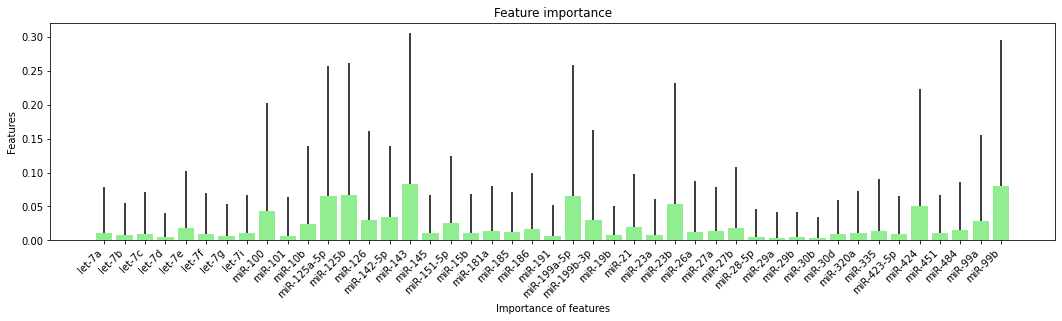

In [32]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
importances = rf.feature_importances_
plot_importance(X_train.columns, importances, std)

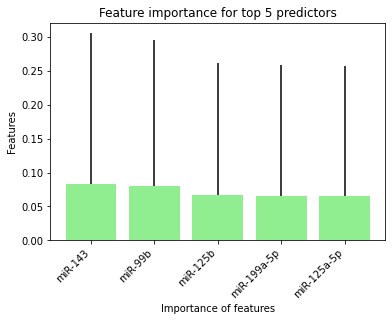

In [33]:
plot_importance(X_train.columns, importances, std, topX = 5)

### Question 
- What is the top features? What does the importance stand for? 
- What would happen if we only retain the top importance features? Will it improve the prediction? (Try it out.)

# 3.5 Measuring performance - Receiver operator curves

Calculate some performance stats.

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label="T" )
roc_auc = roc_auc_score(y_test, probs)
print(roc_auc)


0.8282828282828283


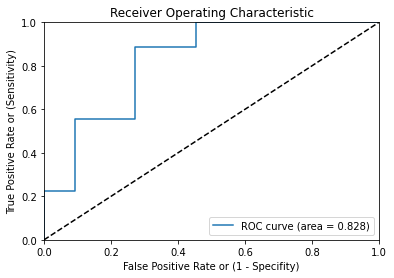

In [35]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc) # https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Extra practices: 
- Try out on a linear classifiers, logistic regression models
    - check more linear models: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
    

- What happen if you do a linear regression?

In [36]:
mapping = {"T":1,"N":0 }
y_train_num = y_train.replace(mapping, inplace=False)
y_test_num = y_test.replace(mapping, inplace=False)
y_test_num.values

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [37]:
from sklearn.linear_model import LinearRegression
# Ordinary least squares Linear Regression.
reg = LinearRegression().fit(X_train, y_train_num)
reg.score(X_train, y_train_num)


1.0

In [45]:
predict_linear = reg.predict(X_test) #classes predictions for the test-set


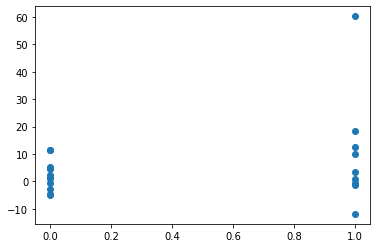

In [46]:
plt.scatter(y_test_num, predict_linear)
# The predicted values are numerical. We need to convert it back to categorical prediction.
# How would you set the cutoff to convert linear fit predictions to categorical predictions? 

In [47]:
cutoff = 3
predict_linear_converted = [0 if i <=cutoff else 1 for i in predict_linear]

[[7 4]
 [4 5]]


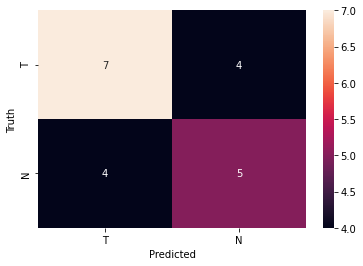

In [48]:
cm_linear = confusion_matrix(y_test_num, predict_linear_converted)
print(cm_linear)
plot_cm(cm_linear)

Logistic regression is suitable to categorical data.


In [49]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=123).fit(X_train, y_train)
y_predict = clf.predict(X_test)
# clf.predict_proba(X_test)
# clf.score(X_test, y_test)

In [50]:
cm_logistic = confusion_matrix(y_test, y_predict, labels = ["T","N"])

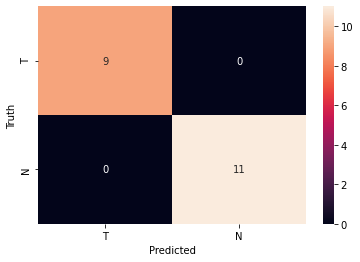

In [51]:
plot_cm(cm_logistic, labels = ["T","N"])

Support Vector Machine
https://scikit-learn.org/stable/modules/svm.html#svm


In [52]:
from sklearn import svm
svm = svm.SVC()
svm.fit(X_train, y_train)
svm_y_predict = svm.predict(X_test)


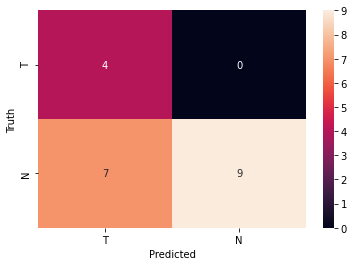

In [53]:
cm_svm = confusion_matrix(svm_y_predict, y_test)
plot_cm(cm_svm)

### Questions
- Out of these classifiers we tested, which one worked the best? What do you think is the reason?
- What is the next step if we want to apply to a new dataset where we don't know the ground truth?

# More Ideas

2. Add K-fold cross validation example
3. Plot OOB error across bags
7. Imputation vs. missing data
8. Pruning
9. Spliting criterion
11. Advanced excercise / Out-of baggings error

# 3.6 Fine tuning random forest model for better performance
There are a few parameters that can be adjusted in a random forest model. Including the number of trees (n_estimators), the depth of trees, bootstraping, class_weight, etc. (press `shift`+`tab` in the ` RandomForestClassifier()` function to see the parameters.)
Here, we explore if changing these parameters alters the predictive power. 


In [55]:
def plotAUC(variable, train_results, test_results, name):
    line1, = plt.plot(variable, train_results, 'b', label='Train AUC')
    line2, = plt.plot(variable, test_results, 'r', label='Test AUC')
    plt.legend()
    plt.title(f"AUC score for different {name}")
    plt.ylabel('AUC score')
    plt.xlabel(f'number of {name}')
    plt.show()

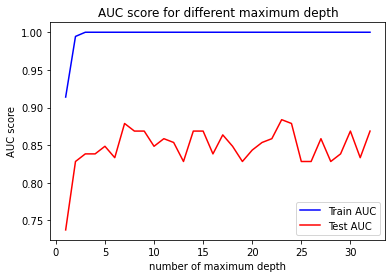

In [56]:
# adjusting max_depth (takes 10 secs)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for depth in max_depths:
    rf= RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred_probs = rf.predict_proba(X_train)[:, 1]
    y_pred_probs = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.values, train_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)

plotAUC(max_depths, train_results, test_results, "maximum depth")


### Question
- In this exercise we tested different maximum depth of the decision trees. What is the optimum max_depth in your opinion?

In [57]:
# adjust n_estimator
max_depth = 8 # also try to change this to see if results differs

train_results = []
test_results = []
n_estimators = np.linspace(1, 400, 50, endpoint=True, dtype = int)
for estimator in n_estimators:
    rf= RandomForestClassifier(n_estimators=estimator, max_depth=max_depth)
    rf.fit(X_train, y_train)
    train_pred_probs = rf.predict_proba(X_train)[:, 1]
    y_pred_probs = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.values, train_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)



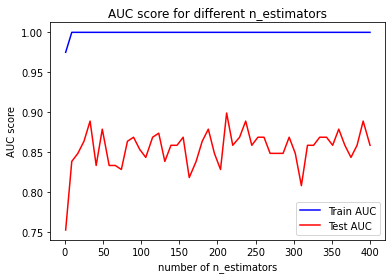

In [58]:
# takes 10 secs
plotAUC(n_estimators, train_results, test_results, "n_estimators")

In [ ]:
# disable bootstrap
max_depth = 8

train_results = []
test_results = []
for estimator in n_estimators:
    rf= RandomForestClassifier(n_estimators=estimator, max_depth=max_depth, bootstrap=False)
    rf.fit(X_train, y_train)
    train_pred_probs = rf.predict_proba(X_train)[:, 1]
    y_pred_probs = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.values, train_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_probs,  pos_label = "T")
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)

plotAUC(n_estimators, train_results, test_results, "n_estimators")

### Questions
- What is the effect of amount of n_estimators and bootstraping?
- What is your ideal random forest classifier for this dataset?
